In [69]:
import os
import re
import numpy as np
import pandas as pd
import regex
import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

from sklearn.cluster import KMeans

# 1.CSV Data Load

- CSV 파일위치 : /result 
- seprator는 '\t'(default)로 encoding 된 csv 사용함('|' 사용시 아래 pd.read_csv에 옵션필요 sep='|'

In [66]:
os.getcwd()
data_path = os.path.join(os.getcwd(), "result")

## 1개만 로드 테스트할경우 사용
#data_name = '201602.csv'
#df = pd.read_csv(os.path.join(data_path, data_name), encoding ='utf-8')
#datetime 날짜형식 변환
#df['Story Date Time'] = pd.to_datetime(df['Story Date Time'] ).dt.floor('d')    

In [98]:
data_file_list = [f for f in os.listdir(data_path) if re.match(r'[0-9]+.*\.csv', f)]
data_file_list.sort()

for datafile_index in range(0, len(data_file_list)):
    
    if datafile_index == 0 :
        # read Data
        df = pd.read_csv(os.path.join(data_path, data_file_list[datafile_index]), encoding ='utf-8')
        #datetime 날짜형식 변환
        df['Story Date Time'] = pd.to_datetime(df['Story Date Time'] ).dt.floor('d')    
    else :
        df_temp = pd.read_csv(os.path.join(data_path, data_file_list[datafile_index]), encoding ='utf-8')
        df_temp['Story Date Time'] = pd.to_datetime(df_temp['Story Date Time'] ).dt.floor('d')
        df = df.append(df_temp, ignore_index=True)
    
    print("[" , data_file_list[datafile_index] , "] loading records = " , len(df) )

[ 201602.csv ] loading records =  21683
[ 201603.csv ] loading records =  47615
[ 201604.csv ] loading records =  71704
[ 201605.csv ] loading records =  93941
[ 201606.csv ] loading records =  116957
[ 201607.csv ] loading records =  141841
[ 201608.csv ] loading records =  165942
[ 201609.csv ] loading records =  188030
[ 201610.csv ] loading records =  213739
[ 201611.csv ] loading records =  239265
[ 201612.csv ] loading records =  262009


In [5]:
#df = pd.read_csv(os.path.join(data_path, data_name), encoding ='utf-8')
#df['Story Date Time'] = pd.to_datetime(df['Story Date Time'] ).dt.floor('d')

#todo : df.dropna()의 경우 아래와 같이 동작하므로, 검토 필요. 일단 Pass
02월 파일의 경우 전처리 모듈을 거쳐 92873 -> 21683

* 위와 같이 사용하면 컬럼 중 결측치가 있으면 무조건 행 삭제함

(1) 결측값이 들어있는 행 전체 삭제하기(delete row with NaN) : df.dropna(axis=0)

(2) 결측값이 들어있는 열 전체 삭제하기 (delete column with NaN) : df.dropna(axis=1)

(3) 특정 행 또는 열을 대상으로 결측값이 들어있으면 제거
    (delete specific row or column with missing values) : df[ ].dropna()

출처: https://rfriend.tistory.com/263 [R, Python 분석과 프로그래밍 (by R Friend)]

In [99]:
# Delete NaN Data Line
print("Origin_Data :", len(df))
df = df.dropna()
print("After Delete :", len(df))
print("Column list : ", df.columns)
df.head()



Origin_Data : 262009
After Delete : 213153
Column list :  Index(['Story Date Time', 'Headline', 'Story Body', 'Index'], dtype='object')


,Story Date Time,Headline,Story Body,Index
0,2016-01-31,"HSBC to freeze salaries, hiring in 2016 in bat...","Europe's largest lender, HSBC, is imposing a h...",3
1,2016-01-31,MEDIA-Germany's Alba finds Asian investor for ...,An Asian company has signed a memorandum of un...,13
2,2016-01-31,Brazil's Petrobras to reduce investment plan b...,Petroleo Brasileiro SA will cut its 2016-2020 ...,38
3,2016-01-31,"Barclays, Credit Suisse to strike record deals...",Barclays and Credit Suisse are poised to settl...,39
4,2016-01-31,"Among White House hopefuls, Trump least likely...",The millions of Twitter users following Donald...,55


In [93]:
# 문장구분자에 대한 처리가 필요할까? 아래 처리로 word건수가 많이 달라짐. 
df['Story Body'] = df['Story Body'].str.replace('     ','.')

"""
적용 :   482746
미적용 : 1014894
"""

# 2. Dictionary Building

# 3. Word2Vec

In [100]:
#입력 기사본문에 대해서 NLTK를 이용하여 문장 토큰화를 수행
corpus_reuter = []

for body_index in range(0, len(df)):
    
    sentence_text = sent_tokenize(df['Story Body'][df.index[body_index]])

    for sentence_index in range(0, len(sentence_text)):
        #Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', sentence_text[sentence_index])

        #Convert to lowercase
        text = text.lower()

        #remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)
        corpus_reuter.append(text.strip().split())

    if( body_index % 50000 == 0):
        print( body_index , "rows tokenizing")
    
print(len(corpus_reuter) , "words completed")

#print(corpus[:100])

0 rows tokenizing
50000 rows tokenizing
100000 rows tokenizing
150000 rows tokenizing
200000 rows tokenizing
1014894 words completed


In [97]:
word2vec_model = Word2Vec(sentences=corpus_reuter, size=300, window=10, min_count=10, workers=4, sg=0)

In [31]:
#문맥적으로 유사한 단어 질의

queries = 'oil korea google jpmorgan steel man hsbc'.split()

for query in queries:

    if not (query in word2vec_model.wv.vocab):
        continue

    print('\n\nQuery = {}\n{}'.format(query, word2vec_model.wv.vocab[query]))

    for sim_word, sim in word2vec_model.wv.most_similar(query):
        sim_count = word2vec_model.wv.vocab[sim_word].count
        print('%s - %s (%d, %.3f)' % (query, sim_word, sim_count, sim))



Query = oil
Vocab(count:52126, index:58, sample_int:4294967296)
oil - petroleum (3579, 0.532)
oil - natural (4604, 0.464)
oil - crude (20099, 0.454)
oil - shale (1545, 0.445)
oil - condensate (452, 0.426)
oil - petrochemical (759, 0.423)
oil - hydrocarbon (82, 0.421)
oil - opec (5486, 0.400)
oil - energy (22966, 0.399)
oil - lng (1564, 0.398)


Query = korea
Vocab(count:3747, index:856, sample_int:4294967296)
korea - korean (1986, 0.671)
korea - sudan (100, 0.662)
korea - pars (17, 0.627)
korea - africans (24, 0.623)
korea - koreans (35, 0.585)
korea - africa (4223, 0.561)
korea - america (5601, 0.554)
korea - carolina (725, 0.520)
korea - morecambe (16, 0.475)
korea - african (1947, 0.462)


Query = google
Vocab(count:2572, index:1190, sample_int:4294967296)
google - alphabet (863, 0.711)
google - facebook (2661, 0.678)
google - android (368, 0.627)
google - whatsapp (264, 0.611)
google - microsoft (1403, 0.602)
google - apple (5957, 0.602)
google - youtube (233, 0.598)
google - sna

In [32]:
for word in queries:
    similar_words = word2vec_model.wv.most_similar(word)
    similar_words = [word for word, sim in similar_words]
    print('similar({}) = {}'.format(
        word, ' '.join(similar_words)))

similar(oil) = petroleum natural crude shale condensate petrochemical hydrocarbon opec energy lng
similar(korea) = korean sudan pars africans koreans africa america carolina morecambe african
similar(google) = alphabet facebook android whatsapp microsoft apple youtube snapchat spotify apps
similar(jpmorgan) = chase citigroup jamie dimon bofa citi rbs ubs fargo merrill
similar(steel) = steelmaking aluminum steelmakers aluminium ore stainless steelmaker nickel coil overcapacity
similar(man) = woman boy born wearing richest son actor alligator mother businessman
similar(hsbc) = ubs barclays rbs citi stanchart lloyds socgen citibank dbs santander


## A. matplot 기본

In [33]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.unicode_minus'] = False

vocab = list(word2vec_model.wv.vocab)
x_dense = word2vec_model[vocab]


tsne = TSNE(n_components=2, perplexity=30)
y_tsne = tsne.fit_transform(x_dense[:150,:])

len(vocab)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


33726

In [34]:
df_vis = pd.DataFrame(y_tsne, index=vocab[:150], columns=['x','y'])
df_vis.shape

(150, 2)

In [35]:
df_vis.head()

,x,y
europe,-79.260078,-192.509903
s,-34.563828,70.128502
largest,224.939011,-17.855495
lender,114.622498,-139.611755
hsbc,72.190338,-66.935265


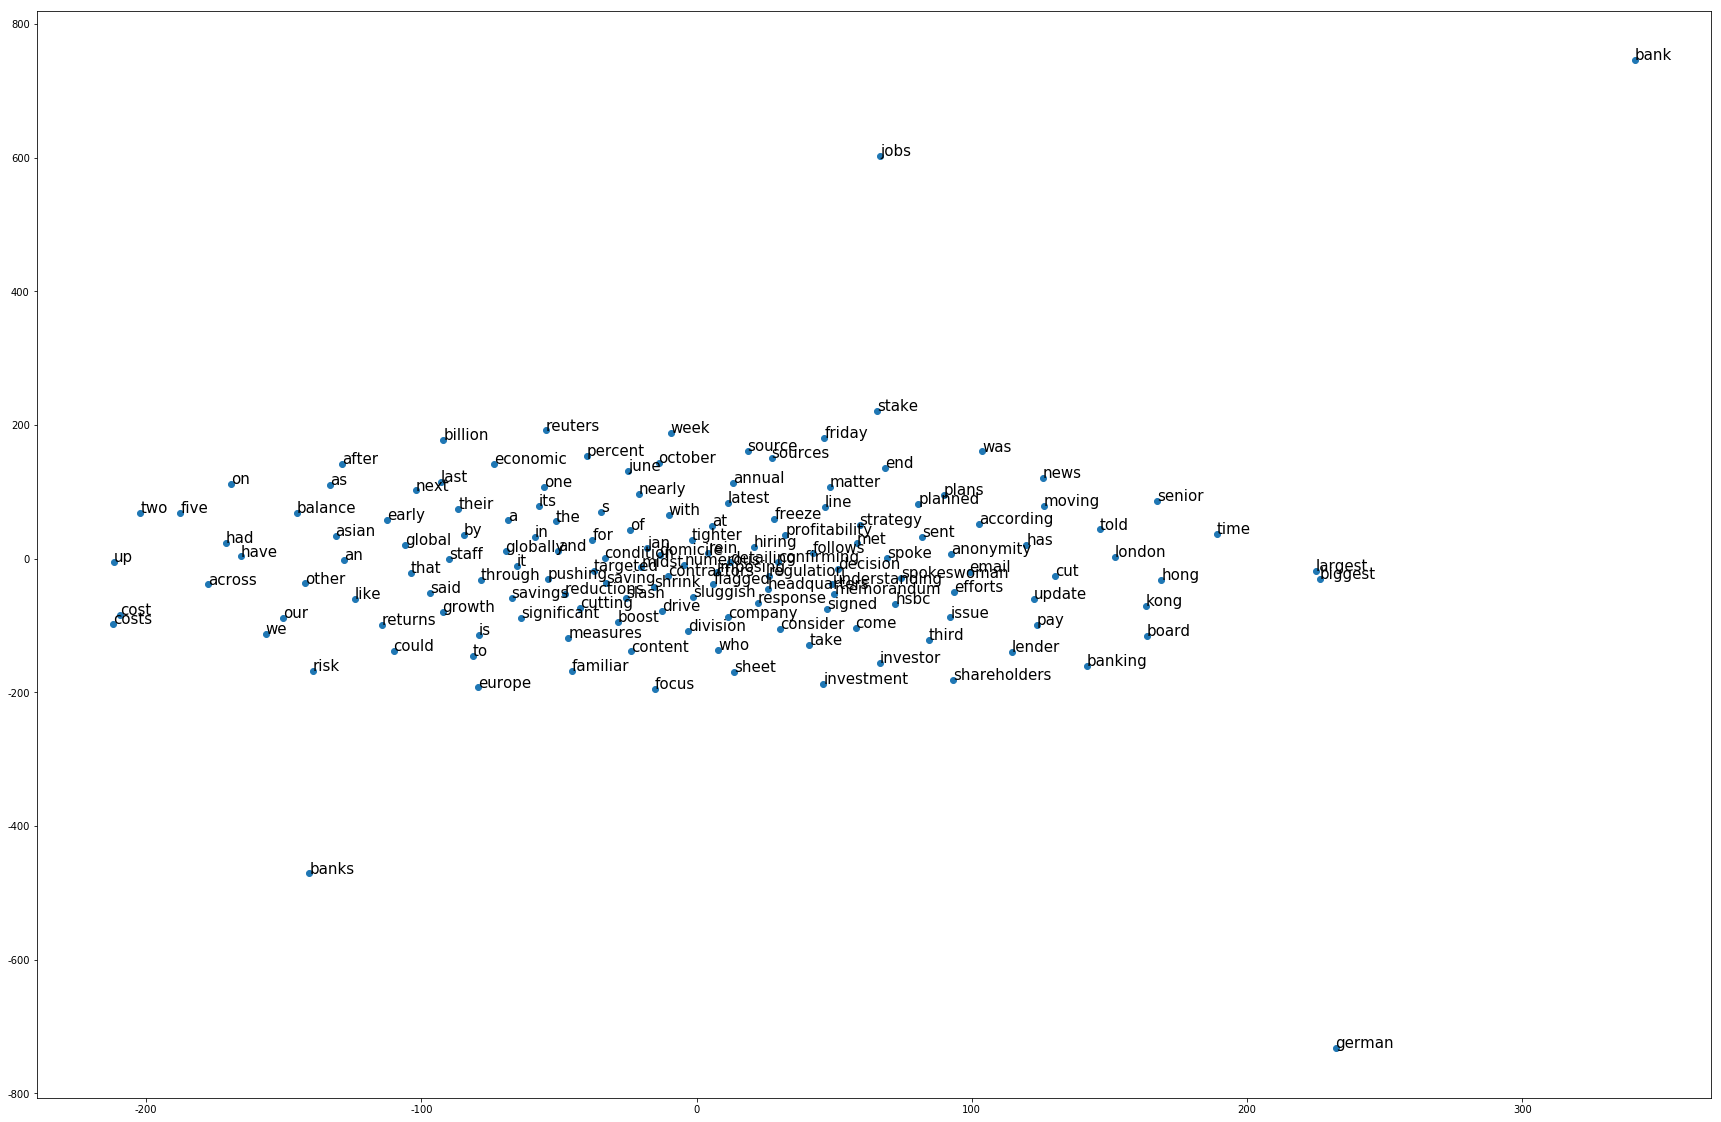

In [36]:
fig = plt.figure()
fig.set_size_inches(30,20)
ax = fig.add_subplot(1,1,1)

ax.scatter(df_vis['x'], df_vis['y'])

for word, pos in df_vis.iterrows():
    ax.annotate(word,pos,fontsize=15)
    
plt.show()

## B.t-SNE embedding

In [37]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


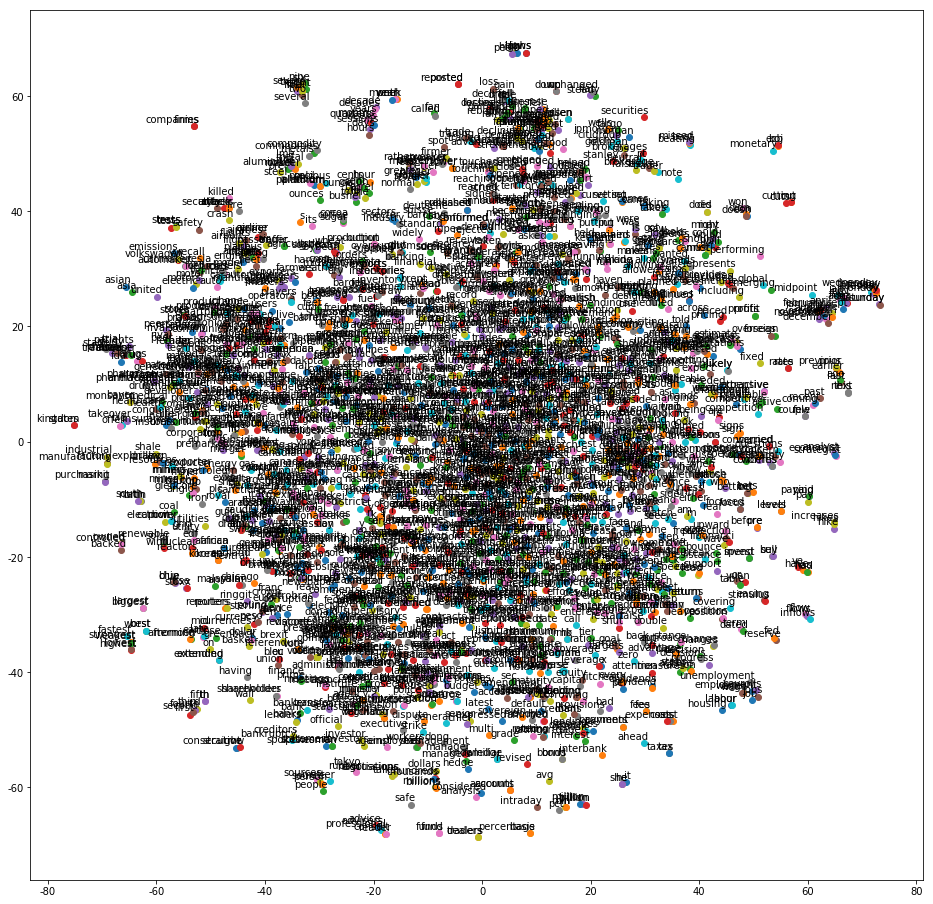

In [43]:
word2vec_model2 = Word2Vec(sentences=corpus_reuter, size=300, window=10, min_count=1000, workers=4, sg=0)

tsne_plot(word2vec_model2)

## C.t-SNE2 with bokeh

In [57]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(word2vec_model2.wv.vocab)))

2,497 terms in the word2vec vocabulary.


In [58]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in word2vec_model2.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x: -x[2])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
# create a DataFrame with the word2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(word2vec_model2.wv.syn0[:],
                            index=ordered_terms)

word_vectors[:10]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.321578,1.040639,0.184564,-0.019053,0.180273,-0.279454,0.768766,-1.245222,-0.189732,0.046472,...,0.635801,1.044116,1.371067,-0.492124,0.666289,0.798940,-0.422252,-0.396482,-0.268582,1.109248
to,-0.790405,0.318132,-2.348168,-2.148816,-0.074722,0.476602,-1.456772,-2.105813,-0.907749,-0.720948,...,-2.024844,1.426881,1.599478,-0.693360,-0.371484,-0.027540,-1.216765,-0.929678,0.614771,1.275871
of,-0.525226,-1.128502,0.417974,0.242638,-0.933150,0.515555,-0.826070,0.596279,-0.663736,-0.746783,...,-1.670065,1.207054,0.043763,-0.135459,0.161119,0.537846,-0.199766,0.827362,2.116827,-0.559489
in,-0.726398,-0.648384,-2.053905,0.225172,1.717053,1.117940,-1.571999,-0.591457,0.735784,0.113073,...,-0.585263,-0.846122,-0.695183,-0.384008,1.457406,-0.211795,-0.360788,0.525434,0.126635,-1.045593
a,0.239022,-0.289669,-0.607828,1.453526,-0.716235,0.940255,2.873996,-0.994573,-1.172263,0.504178,...,-0.536041,0.017656,1.069501,-0.584487,0.799838,-0.323455,1.523397,0.264870,-0.817200,-0.297544
and,0.090136,0.333866,2.264419,1.638216,-0.021195,0.450905,-2.407720,-0.106750,0.971280,-0.522402,...,-0.987146,-0.346818,-0.608124,-0.549240,0.565000,1.237084,0.406481,0.265410,0.186774,-1.034538
s,-0.519579,-0.050685,0.579351,1.948845,0.185965,-0.350232,0.797117,-0.288675,2.613887,1.396605,...,0.192916,-0.027953,0.956644,-1.790518,0.239129,0.469022,0.640108,1.640633,-1.248579,-0.420359
on,-3.383799,-0.274019,-1.850058,1.039958,2.188842,0.218978,-1.468666,-0.529991,1.198211,0.272144,...,0.726506,0.245088,-0.754861,-0.382602,-1.420108,1.625009,1.167080,-0.488074,-1.299266,0.196583
is,0.666267,-0.629520,2.208772,2.604591,-0.328650,-1.162240,1.729022,-1.948174,1.854860,0.766054,...,-0.850190,0.743871,-0.100617,1.718537,0.628109,-0.735352,0.837855,-0.785608,0.407180,0.217194
for,1.054693,0.677135,-1.108923,-1.763100,0.368258,1.500070,-1.184602,-1.016510,0.630571,0.143734,...,0.453524,1.545050,0.061713,-1.028977,0.330971,1.031347,0.380248,-0.553731,0.582615,0.019287


In [59]:
import spacy
nlp_spacy = spacy.load("en")

tsne_input = word_vectors.drop(nlp_spacy.Defaults.stop_words, errors=u'ignore')

In [60]:
print(nlp_spacy.Defaults.stop_words)

{'amount', 'less', 'last', 'had', 'any', 'all', 'get', 'beforehand', 'back', 'somehow', 'hers', 'everything', 'besides', 'show', 'noone', 'off', 'from', '‘ve', 'within', 'except', 'only', 'using', 'front', 'anywhere', 'four', 'n’t', 'herself', 'myself', 'alone', 'between', 'bottom', 'up', 'an', 'ourselves', 'also', 'someone', '’d', 'again', 'quite', 'can', 'rather', 'top', 'wherein', "n't", 'anyhow', 'thereafter', 'about', 'sometimes', 'whoever', 'due', 'whether', 'or', 'that', 'whence', 'first', 'whereby', 'part', 'next', '‘m', 'enough', 'elsewhere', 'most', 'became', 'to', 'her', 'so', "'ll", 'we', 'ten', 'else', 'as', 'serious', 'yet', 'anything', 'here', 'some', 'either', 'empty', 'many', '’s', 'becoming', 'no', 'though', 'used', 'seem', 'hundred', 'often', 'via', 'will', 'is', 'well', 'with', 'upon', 'whatever', 'but', 'been', 'among', 'would', 'onto', 'mostly', 'out', 'various', 'more', 'than', 'six', 'few', 'just', 'too', 'nobody', 'towards', 'anyone', 'latterly', 'under', 'by',

In [61]:
tsne = TSNE()
tsne_vectors = tsne.fit_transform(tsne_input.values)

In [62]:
tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])
tsne_vectors.head()

tsne_vectors[u'word'] = tsne_vectors.index

In [65]:

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings by bokeh',
                   plot_width = 800,
                   plot_height = 800,
                   tooltips = u'@word',
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
#tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
#tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# 4. clustering( from 'word2vec' vector by K-means)

## K-means (K평균)클러스터링으로 데이터 묶기

* [K-평균 알고리즘 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)

- 클러스터링은 비지도 학습 기법
- 클러스터링은 유사성 등 개념에 기초해 몇몇 그룹으로 분류하는 기법
- 클러스터링의 목적은 샘플(실수로 구성된 n차원의 벡터)을 내부적으로는 비슷하지만 외부적으로 공통 분모가 없는 여러 그룹으로 묶는 것
- 특정 차원의 범위가 다른 차원과 차이가 크면 클러스터링 하기 전에 스케일을 조정해야 한다.

    1. 최초 센트로이드(centroid)(중심점)로 k개의 벡터를 무작위로 선정한다.
    2. 각 샘플을 그 위치에서 가장 가까운 센트로이드에 할당한다.
    3. 센트로이드의 위치를 재계산한다.
    4. 센트로이드가 더 이상 움직이지 않을 때까지 2와 3을 반복한다.

참고 : [책] 모두의 데이터 과학(with 파이썬)

In [70]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5 이나 평균 5단어로 설정한다.
word_vectors = word2vec_model2.wv.syn0 # 어휘의 feature vector
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)
print('clustering 크기(갯수) 설정값 =', num_clusters)

# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난시간에서 시작시간을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")\

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """


clustering 크기(갯수) 설정값 = 499
Time taken for K Means clustering:  8.68631386756897 seconds.


In [80]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = word2vec_model2.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫번째 클러스터의 처음 10개를 출력
for cluster in range(0,500):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))
    
    # 클러스터번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['lead', 'break', 'cause']

Cluster 1
['buyers', 'cheaper', 'cheap']

Cluster 2
['russia', 'russian', 'rosneft']

Cluster 3
['italian', 'bad', 'banca', 'di', 'banco', 'monte', 'paschi', 'dei', 'unicredit', 'popolare']

Cluster 4
['hours', 'minutes', 'night']

Cluster 5
['fifth', 'th']

Cluster 6
['growth', 'performance', 'profits', 'margins', 'quality', 'leverage', 'profitability', 'returns', 'profile']

Cluster 7
['products', 'product', 'security', 'software', 'systems', 'samsung', 'medical', 'phone', 'devices', 'iphone', 'device', 'smartphone', 'recall', 'heart']

Cluster 8
['known', 'opportunity', 'buyer', 'example']

Cluster 9
['need', 'include', 'provide', 'allow', 'receive', 'require']

Cluster 10
['credit', 'loan', 'facility', 'facilities', 'secured', 'unsecured', 'principal', 'maturity', 'amendment', 'revolving']

Cluster 11
['china', 'japan', 'india', 'canada', 'australia', 'indonesia', 'malaysia', 'vietnam', 'southeast', 'thailand', 'philippines']

Cluster 12
['bee

['ll']

Cluster 95
['rates']

Cluster 96
['south', 'north', 'latin']

Cluster 97
['hit', 'settled', 'hitting', 'touched', 'reaching', 'touching']

Cluster 98
['take', 'hold', 'get', 'give', 'face', 'find', 'respond', 'consider', 'seek', 'extend', 'discuss', 'replace', 'announce', 'agree', 'present', 'decide', 'join', 'enter']

Cluster 99
['says', 'acquisition', 'purchase', 'transaction', 'date', 'closing', 'fully', 'effective', 'remaining', 'complete', 'option', 'consideration', 'subject', 'amounts', 'completion', 'upon', 'maximum']

Cluster 100
['decade', 'decades']

Cluster 101
['weather', 'season', 'winter', 'summer', 'red', 'weekend', 'inventory', 'grain', 'farmers', 'dry', 'heating', 'midwest', 'spring']

Cluster 102
['tonnes']

Cluster 103
['pharmaceuticals', 'drugmaker', 'valeant', 'antitrust', 'pfizer', 'pharma', 'johnson', 'pharmaceutical', 'generic', 'allergan', 'patent']

Cluster 104
['trading', 'spot', 'slightly', 'steady', 'volumes', 'gulf', 'bids', 'largely', 'mainly', 'm

['tv', 'video', 'advertising', 'game', 'live', 'popular', 'games', 'television', 'shopping', 'app']

Cluster 207
['own', 'help', 'use', 'reduce', 'control', 'build', 'access', 'improve', 'create', 'turn', 'bring', 'drive', 'cover', 'transfer', 'maintain', 'ensure', 'avoid', 'operate', 'address', 'carry', 'strengthen', 'secure', 'protect', 'manage']

Cluster 208
['digit']

Cluster 209
['has', 'have', 'had', 've']

Cluster 210
['financial', 'asset', 'banking', 'liquidity', 'funding', 'ongoing', 'internal', 'operational', 'provisions', 'external']

Cluster 211
['targets']

Cluster 212
['blue', 'chip']

Cluster 213
['pipeline', 'port', 'shipping', 'sea', 'cargo', 'terminal', 'lng', 'black', 'freight', 'ship', 'vessels']

Cluster 214
['position', 'positions']

Cluster 215
['wave']

Cluster 216
['qatar', 'dubai', 'abu', 'dhabi']

Cluster 217
['export', 'fuel', 'shipments', 'purchases', 'import', 'exporter']

Cluster 218
['stores', 'store']

Cluster 219
['poll', 'survey']

Cluster 220
['ratio

['quoted']

Cluster 333
['increase', 'increased', 'grew', 'decrease', 'decreased', 'amounted']

Cluster 334
['wang', 'tao', 'technicals']

Cluster 335
['street']

Cluster 336
['acquire']

Cluster 337
['avg']

Cluster 338
['jobs', 'payrolls']

Cluster 339
['conference', 'reporters']

Cluster 340
['treasury', 'treasuries']

Cluster 341
['composite']

Cluster 342
['more', 'less', 'rather']

Cluster 343
['cuts', 'increases', 'hikes']

Cluster 344
['hk', 'rmb']

Cluster 345
['tax', 'taxes']

Cluster 346
['statement', 'spokesman', 'spokeswoman']

Cluster 347
['investors']

Cluster 348
['filing']

Cluster 349
['much', 'such', 'well']

Cluster 350
['fallen', 'risen']

Cluster 351
['soy']

Cluster 352
['plan', 'planned', 'looking', 'working', 'seeking', 'needed', 'scheduled', 'considering', 'required', 'planning', 'ready', 'necessary', 'designed']

Cluster 353
['chief', 'ceo', 'chairman', 'cfo']

Cluster 354
['attributable']

Cluster 355
['said', 'added', 'say', 'saying', 'warned', 'wrote', 'su

In [79]:
len(word_centroid_map)

2497

# 5.TF-IDF keyword extrection

## TF-IDF
TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

역문서 빈도(IDF)는 한 단어가 문서 집합 전체에서 얼마나 공통적으로 나타나는지를 나타내는 값이다. 전체 문서의 수를 해당 단어를 포함한 문서의 수로 나눈 뒤 로그를 취하여 얻을 수 있다.

* 출처 : [TF-IDF - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/TF-IDF)

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 싸이킷런 공식문서 : [4.2. Feature extraction — scikit-learn 0.19.1 documentation](http://scikit-learn.org/stable/modules/feature_extraction.html)

In [82]:
str = '첫번째문장입니다     두번째문장입니다'
print( str.replace('     ','.'))

첫번째문장입니다.두번째문장입니다
